In [1]:
import math
import os
import scipy
from scipy.optimize import lsq_linear
import numpy as np
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, halfnorm
import random
from scipy.io import loadmat
import random
import pickle
import sys
from sklearn.linear_model import RidgeCV
sys.path.append(r"c:\Users\katie\OneDrive\Documents\GitHub\trial")
import PCA_Regress as pcar

In [2]:
base_path =r"c:\Users\katie\OneDrive\Desktop\Thesis"
with open(base_path+'\J_neu.pkl', "rb") as input_file:
    J_pickle = pickle.load(input_file)
del input_file

file_path = os.path.join(base_path, 'N_neu.pkl')
with open(file_path, "rb") as input_file:
    N_pickle = pickle.load(input_file)
del input_file

base_path =r"c:\Users\katie\OneDrive\Desktop\Thesis"
with open(base_path+'\J_mus.pkl', "rb") as input_file:
    J_pickle_m = pickle.load(input_file)
del input_file

ile_path = os.path.join(base_path, 'N_mus.pkl')
with open(ile_path, "rb") as input_file:
    N_pickle_m = pickle.load(input_file)
del input_file

# base_path = "/Users/kb6113/Desktop/Thesis"
# with open(base_path+'/J_neu.pkl', "rb") as input_file:
#     J_pickle = pickle.load(input_file)
# del input_file

# with open(base_path+'/J_mus.pkl', "rb") as input_file:
#     J_pickle_m = pickle.load(input_file)
# del input_file

J_all_tensor = J_pickle['J_all']['interpPSTH']
J_M1_tensor = J_pickle['J_M1']['interpPSTH']
J_PMd_tensor = J_pickle['J_PMd']['interpPSTH']
J_mus_tensor = J_pickle_m['interpPSTH']
J_mus_stack = np.vstack((J_mus_tensor, J_mus_tensor, J_mus_tensor, J_mus_tensor))


N_all_tensor = N_pickle['N_all']['interpPSTH']
N_M1_tensor = N_pickle['N_M1']['interpPSTH']
N_PMd_tensor = N_pickle['N_PMd']['interpPSTH']
N_mus_tensor = N_pickle_m['interpPSTH']

<>:2: SyntaxWarning: invalid escape sequence '\J'
<>:12: SyntaxWarning: invalid escape sequence '\J'
<>:2: SyntaxWarning: invalid escape sequence '\J'
<>:12: SyntaxWarning: invalid escape sequence '\J'
C:\Users\katie\AppData\Local\Temp\ipykernel_44840\3559308067.py:2: SyntaxWarning: invalid escape sequence '\J'
  with open(base_path+'\J_neu.pkl', "rb") as input_file:
C:\Users\katie\AppData\Local\Temp\ipykernel_44840\3559308067.py:12: SyntaxWarning: invalid escape sequence '\J'
  with open(base_path+'\J_mus.pkl', "rb") as input_file:


>>> best_lam returning: 0.01


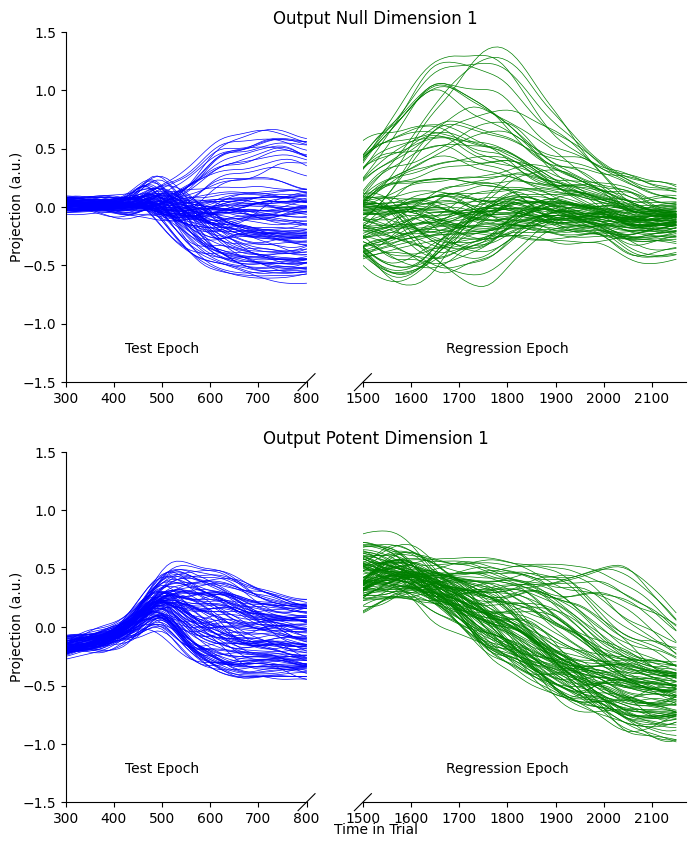

In [8]:
W,_,_,_,_,_,_ = pcar.fig_4(J_PMd_tensor, J_M1_tensor, plot = True, basis = 0, dimensions = 14)
tensor_N = J_PMd_tensor
tensor_M = J_M1_tensor
dimensions = 14


cond, _, fin_tim = tensor_N.shape

if fin_tim < 229:
    J = False
else: 
    J = True       # identifies what data set it is working with and will ensure the correct timecuts occur

# scaling, mean centering, and involving only the time periods needed for regression (the movement)
regress_N, _, regress_M = pcar.time_shift(tensor_N, tensor_M, tensors = False)
time_ct = regress_M.shape [0]
time_ct_neu = regress_N.shape [0]

# how many time bins are included in the movement period 
time_bins = int(time_ct / cond)

# how many time bins are included in the preparatory and movement period 
time_bins_pm = int(time_ct_neu / cond)

# difference in bins 
diff_bin = int((time_bins_pm - time_bins))

# retrieving data projected onto the first N_dim and M_dim PCs
N_tilde,_,_ = pcar.run_PCA(regress_N, dimensions, mc = False)
M_tilde,PCs,_ = pcar.run_PCA(regress_M, int(dimensions/2), mc = False)

# removing preparatory time bins
N_tilde_tens = pcar.shape_tensor(N_tilde, cond, time_bins_pm)
N_tilde_tens_move = N_tilde_tens[:,:,diff_bin:]
N_tilde_tens_prep = N_tilde_tens[:,:,:diff_bin]

# reshape for ridge
N_tilde_move = pcar.shape_matrix(N_tilde_tens_move)
N_tilde_prep = pcar.shape_matrix(N_tilde_tens_prep)

U, S_val, V = np.linalg.svd(W)
rank = int(dimensions/2)

# potent and null space basis of W 
W_potent = U[:,:rank]
W_null = U[:,rank:]

In [11]:
def tuning_rat (W_potent, W_null, neu_move, neu_prep):
    
    # movement null and potent space for gamma 
    N_null_move = neu_move @ W_null 
    null_move_frob = np.linalg.norm(N_null_move)

    N_pot_move = neu_move @ W_potent
    pot_move_frob = np.linalg.norm(N_pot_move)

    gamma = null_move_frob / pot_move_frob

    # Null and potent projections of movement neural data 
    N_null_prep = neu_prep @ W_null 
    N_null_prep -= np.mean(N_null_prep, axis = 0)       # subtract columns for variance
    null_prep_frob = np.linalg.norm(N_null_prep)

    N_pot_prep = neu_prep @ W_potent
    N_pot_prep -= np.mean(N_pot_prep, axis = 0)         # subtract columns for variance
    pot_prep_frob = np.linalg.norm(N_pot_prep)

    tuning = (null_prep_frob / pot_prep_frob) / gamma

    return tuning








In [12]:
tuning = tuning_rat(W_potent, W_null, N_tilde_move, N_tilde_prep)
print(tuning)

1.0250194223232771
